In [1]:
import os
from preprocess import folds
import segmentation_models_pytorch as smp
from monai.data import DataLoader, Dataset
import torch
from tqdm import tqdm
torch.autograd.set_detect_anomaly(True)
root_dir = os.path.join(".", "output")

In [2]:
gpu = "cuda"

In [3]:
if gpu == "cuda":
    device = torch.device("cuda:0")
loss_function = smp.losses.DiceLoss(mode="binary", from_logits=False)

In [4]:
# loss_function2 = smp.losses.FocalLoss(mode="binary", alpha=0.9, gamma=2.0)

# Create the UNet model with the specified backbone
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,
    classes=1,
    activation="sigmoid",
    encoder_weights=None
).to(device)

In [4]:
from model import TransformerAttentionUNet

model = TransformerAttentionUNet(128, 4, 256, 3, 8).to(device)

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True).to(device)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [6]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []


num_CV = 5
max_epochs = 20
epoch_per_CV = max_epochs // num_CV

for i in range(num_CV):

    print("-" * 10)
    print(f"Fold {i}")
    train_ds = folds[i]["train"]
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
    val_ds = folds[i]["val"]
    val_loader = DataLoader(val_ds, batch_size=8, num_workers=4)

    if i < num_CV - 1:
        start_epoch = i * epoch_per_CV
        end_epoch = (i + 1) * epoch_per_CV
    else:
        start_epoch = i * epoch_per_CV
        end_epoch = max_epochs

    for epoch in range(start_epoch, end_epoch):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        # Training
        model.train()
        epoch_loss = 0
        step = 0

        for batch_data in tqdm(train_loader, desc="Training"):
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
    
            if torch.isnan(loss) or torch.isnan(torch.flatten(outputs)).any().item():
                print(outputs)
                print(torch.isnan(torch.flatten(outputs)).any())
                print(labels)
                print(loss)

            scaler.scale(loss).backward()
            if step % 100 == 0:
                for name, param in model.named_parameters():
                    print(name, param.shape)
                    print(param.grad)
                    print("\n\n\n\n\n")
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Validation
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_iou = 0.0
            num_batches = len(val_loader)

            with torch.no_grad():
                for val_data in tqdm(val_loader, desc="Validation"):
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )

                    val_outputs = model(val_inputs)
                    val_outputs = (val_outputs > 0.5).float()  # Assuming sigmoid activation

                    # Calculate Dice for the batch
                    intersection = torch.sum(val_outputs * val_labels)
                    union = torch.sum(val_outputs) + torch.sum(val_labels) - intersection
                    iou = (intersection + 1e-15) / (union + 1e-15)
                    val_iou += iou.item()

            # Calculate average IoU across all batches
            average_val_iou = val_iou / num_batches
            metric_values.append(average_val_iou)

            if average_val_iou > best_metric:
                best_metric = average_val_iou
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(
                f"current epoch: {epoch + 1} current mean IoU: {average_val_iou:.4f}"
                f"\nbest mean IoU: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
Fold 0
----------
epoch 1/20


Training:  82%|████████▏ | 99/121 [00:12<00:02,  9.30it/s]

encoder.conv1.weight torch.Size([64, 3, 7, 7])
tensor([[[[-1.1492e+01, -1.2805e+01, -1.5422e+01,  ..., -2.7422e+01,
           -3.8375e+01, -4.7375e+01],
          [-8.5703e+00, -9.3828e+00, -1.3289e+01,  ..., -2.8859e+01,
           -3.7156e+01, -4.9281e+01],
          [-6.9453e+00, -7.9492e+00, -1.1781e+01,  ..., -2.6141e+01,
           -3.5062e+01, -5.0219e+01],
          ...,
          [-4.6367e+00, -3.6914e+00, -7.6875e+00,  ..., -2.1422e+01,
           -3.0641e+01, -4.0031e+01],
          [-5.3008e+00, -6.0859e+00, -1.1531e+01,  ..., -2.2188e+01,
           -3.0406e+01, -3.7312e+01],
          [-4.7109e+00, -6.9727e+00, -1.3633e+01,  ..., -2.3203e+01,
           -2.8750e+01, -3.0625e+01]],

         [[-1.1492e+01, -1.2805e+01, -1.5422e+01,  ..., -2.7422e+01,
           -3.8375e+01, -4.7375e+01],
          [-8.5703e+00, -9.3828e+00, -1.3289e+01,  ..., -2.8859e+01,
           -3.7156e+01, -4.9281e+01],
          [-6.9453e+00, -7.9492e+00, -1.1781e+01,  ..., -2.6141e+01,
           

Training:  83%|████████▎ | 100/121 [00:12<00:04,  4.62it/s]

tensor([[[[-8.1863e-03, -3.3752e-02,  6.6956e-02],
          [-2.3514e-02, -6.4026e-02,  2.1558e-01],
          [ 5.4054e-03,  8.8074e-02,  1.0724e-01]],

         [[ 4.3610e-02,  4.3604e-01,  4.0405e-01],
          [ 2.7563e-01,  3.3618e-01,  4.5197e-02],
          [ 3.5620e-01,  2.7466e-01,  1.5942e-01]],

         [[ 1.8982e-01,  3.4717e-01,  5.7324e-01],
          [ 2.0081e-02,  3.0908e-01,  4.4043e-01],
          [-2.9614e-01,  3.2202e-01,  3.9185e-01]],

         ...,

         [[ 1.5076e-01,  2.1240e-02,  4.8553e-02],
          [-9.2224e-02, -1.2634e-01,  4.8584e-02],
          [ 4.3976e-02, -6.2622e-02, -1.8082e-02]],

         [[ 1.3513e-01,  1.6785e-01,  7.8674e-02],
          [ 3.3496e-01,  2.8931e-01,  4.2114e-01],
          [ 2.9810e-01,  4.8682e-01,  6.9946e-02]],

         [[-2.7100e-02, -3.0853e-02,  1.2585e-01],
          [-6.7688e-02,  1.4221e-02, -1.4478e-01],
          [ 7.9651e-02,  1.2134e-01,  9.4543e-02]]],


        [[[-1.3623e-01, -1.2292e-01, -1.1993e-01],
  

Training: 100%|██████████| 121/121 [00:15<00:00,  7.85it/s]


epoch 1 average loss: 0.9383
----------
epoch 2/20


Training:  82%|████████▏ | 99/121 [00:11<00:02,  9.16it/s]

encoder.conv1.weight torch.Size([64, 3, 7, 7])
tensor([[[[ 9.7266e+00,  1.6312e+01,  2.0875e+01,  ...,  3.0375e+01,
            2.6703e+01,  2.2844e+01],
          [-5.6328e+00, -8.4375e-01, -1.8125e+00,  ..., -1.9688e+00,
            6.9609e+00, -8.4531e+00],
          [-2.9297e+01, -3.7812e+01, -3.6625e+01,  ..., -3.8219e+01,
           -5.0531e+01, -8.0438e+01],
          ...,
          [-6.0562e+01, -6.9500e+01, -9.3688e+01,  ..., -1.6425e+02,
           -2.0725e+02, -2.2762e+02],
          [-7.4250e+01, -9.0500e+01, -1.2462e+02,  ..., -2.1100e+02,
           -2.3150e+02, -2.3925e+02],
          [-1.0650e+02, -1.3025e+02, -1.5425e+02,  ..., -2.3250e+02,
           -2.4975e+02, -2.2888e+02]],

         [[ 9.7266e+00,  1.6312e+01,  2.0875e+01,  ...,  3.0375e+01,
            2.6703e+01,  2.2844e+01],
          [-5.6328e+00, -8.4375e-01, -1.8125e+00,  ..., -1.9688e+00,
            6.9609e+00, -8.4531e+00],
          [-2.9297e+01, -3.7812e+01, -3.6625e+01,  ..., -3.8219e+01,
           

Training:  83%|████████▎ | 100/121 [00:11<00:04,  4.77it/s]

tensor([-2.4182e+00, -4.6041e-01, -6.6305e-01,  1.3709e+00,  6.1982e-02,
        -2.7556e-01, -2.2413e-01,  1.5280e+00,  1.6695e+00,  7.0573e-03,
         1.3308e+00,  3.6902e-01,  1.1900e+00,  6.8464e-01,  1.8664e+00,
         9.8683e-01,  2.7843e-01, -8.8181e-01, -2.6102e-01, -4.7151e-01,
        -4.6793e-01, -5.3069e-01,  2.6685e-02,  7.7232e-01, -1.9613e-01,
         2.3299e-02, -7.9461e-02,  2.6046e-01,  3.0409e+00, -1.5859e+00,
        -4.1477e-01,  9.5669e-01,  1.5924e-01,  3.7059e+00,  5.6308e-01,
         7.7770e-01, -4.3372e-01,  2.8443e+00, -2.0809e-01, -1.4576e+00,
        -7.9130e-01,  1.6832e+00,  1.6575e+00,  5.1138e-01,  3.0068e-02,
        -6.0365e-01, -1.9373e-02, -6.6640e-01,  6.2478e-01, -1.1640e+00,
        -4.8629e-01, -1.5744e-01,  1.3410e+00, -2.6252e-01,  7.5374e-02,
         2.1487e-02, -1.4704e-01, -6.7162e-01, -1.0038e+00, -1.2943e-01,
         1.7451e+00,  1.6222e-01,  3.7828e-02,  2.1730e-01, -7.3755e-02,
         7.9854e-02, -6.4065e-02, -2.2558e-02,  2.7

Training: 100%|██████████| 121/121 [00:14<00:00,  8.56it/s]


epoch 2 average loss: 0.8504


Validation: 100%|██████████| 121/121 [00:01<00:00, 84.97it/s] 


saved new best metric model
current epoch: 2 current mean IoU: 0.4294
best mean IoU: 0.4294 at epoch: 2
----------
epoch 3/20


Training:  82%|████████▏ | 99/121 [00:11<00:02,  9.19it/s]

encoder.conv1.weight torch.Size([64, 3, 7, 7])
tensor([[[[  216.8750,   223.7500,   226.5000,  ...,   187.3750,
             213.2500,   399.7500],
          [  244.0000,   253.5000,   244.1250,  ...,   222.0000,
             396.5000,   491.7500],
          [  282.0000,   279.5000,   247.0000,  ...,   121.5000,
             452.2500,   710.5000],
          ...,
          [  340.7500,   311.5000,   299.2500,  ...,   224.6250,
             570.5000,   976.0000],
          [  390.5000,   349.7500,   307.5000,  ...,   402.5000,
             769.5000,  1064.0000],
          [  468.7500,   394.7500,   321.2500,  ...,   568.0000,
             978.5000,  1158.0000]],

         [[  216.8750,   223.7500,   226.5000,  ...,   187.3750,
             213.2500,   399.7500],
          [  244.0000,   253.5000,   244.1250,  ...,   222.0000,
             396.5000,   491.7500],
          [  282.0000,   279.5000,   247.0000,  ...,   121.5000,
             452.2500,   710.5000],
          ...,
          [ 

Training:  83%|████████▎ | 100/121 [00:11<00:04,  4.59it/s]

tensor([-2.7964e-01,  1.0944e-01,  1.9842e+00,  9.9047e-01, -7.3762e-01,
         9.5391e-01, -2.9139e+00, -3.8526e+00,  6.8195e-01,  2.2082e+00,
        -4.9378e+00,  3.1422e+00,  2.6312e+00,  3.0846e+00, -2.0790e+00,
        -5.1839e+00, -8.3694e-01, -7.2084e-01, -1.3279e+00,  1.7497e+00,
        -1.2371e+00,  6.9945e-02, -6.3220e-02,  3.3695e+00, -9.2488e-01,
        -3.8722e-01, -2.9775e-02, -3.8717e-01,  9.6190e-01, -2.7128e+00,
        -4.2134e+00, -9.3561e-01,  9.9882e-01,  1.5716e-01,  3.6023e+00,
        -4.9426e-01, -2.8360e+00, -4.2265e+00, -1.8416e-01, -5.8154e+00,
        -4.8315e+00, -1.3413e+00, -2.0911e+00,  5.0147e-01, -1.1228e+01,
        -1.3823e+00,  5.6358e-01,  3.0861e-01, -1.4964e+00, -2.6483e-01,
         1.7298e+00, -2.9595e-01, -1.1319e+00,  1.9665e+00,  1.9171e+00,
        -2.6107e+00, -2.1203e+00,  3.3158e+00,  1.0573e+00, -3.7633e+00,
         9.3418e-02,  1.1890e+00,  1.7222e+00, -1.9692e-01, -3.0569e+00,
        -2.4329e+00, -1.5172e+00, -1.1967e+00,  3.2

Training: 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


epoch 3 average loss: 0.6458
----------
epoch 4/20


Training:  82%|████████▏ | 99/121 [00:11<00:02,  8.94it/s]

encoder.conv1.weight torch.Size([64, 3, 7, 7])
tensor([[[[-5.2812e+01, -5.6125e+01, -4.5125e+01,  ..., -5.9250e+01,
           -6.8500e+01, -7.5750e+01],
          [-3.7375e+01, -4.5938e+01, -5.0594e+01,  ..., -9.7000e+01,
           -9.6688e+01, -1.0631e+02],
          [-3.4000e+01, -3.2500e+01, -3.2719e+01,  ..., -9.3562e+01,
           -1.0806e+02, -1.3212e+02],
          ...,
          [-1.4344e+01, -1.4641e+01, -1.6625e+01,  ..., -1.0200e+02,
           -1.4038e+02, -1.7575e+02],
          [-1.5906e+01, -3.0797e+01, -3.9656e+01,  ..., -1.0600e+02,
           -1.3300e+02, -1.6812e+02],
          [-1.5484e+01, -3.1844e+01, -4.8906e+01,  ..., -1.0350e+02,
           -1.1744e+02, -1.5188e+02]],

         [[-5.2812e+01, -5.6125e+01, -4.5125e+01,  ..., -5.9250e+01,
           -6.8500e+01, -7.5750e+01],
          [-3.7375e+01, -4.5938e+01, -5.0594e+01,  ..., -9.7000e+01,
           -9.6688e+01, -1.0631e+02],
          [-3.4000e+01, -3.2500e+01, -3.2719e+01,  ..., -9.3562e+01,
           

Training:  83%|████████▎ | 100/121 [00:11<00:04,  4.66it/s]

tensor([-1.5179e+00, -1.3861e+00, -3.7201e-01,  1.2061e+00, -3.4588e-01,
        -3.2926e-01, -1.7558e-01,  1.8508e+00,  2.8065e-02,  1.4151e+00,
         1.4316e+00, -1.1535e+00,  1.1704e-02, -7.0524e-01, -2.0472e-01,
        -7.4504e-01, -5.1012e-01, -1.7562e+00, -6.5807e-01, -2.8219e-01,
        -5.2111e-01,  3.3759e-01, -5.0688e-01, -1.4083e+00, -2.9092e-01,
        -5.7424e-01,  8.6617e-02,  1.3399e+00,  1.8158e+00, -3.7586e-01,
         9.4767e-02,  3.1279e-01, -9.7776e-01,  2.0994e+00, -1.5241e+00,
        -8.0145e-01, -2.0993e-01,  1.7211e-02, -2.0845e-01,  1.4330e-01,
         1.5522e-01,  3.8069e-01,  9.2676e-01,  2.2815e-01,  1.8165e-01,
        -1.1196e+00, -2.5455e-01, -1.2104e+00,  5.4562e-01,  1.5650e-01,
        -2.3403e-01,  8.5118e-01, -3.4434e-01, -4.6572e-01, -1.7494e+00,
        -6.7746e-01, -1.6267e-01, -2.7871e-01,  1.1260e+00,  5.6511e-02,
        -7.6704e-01, -3.7069e-01, -1.5997e-01, -2.2628e-01, -1.5818e-03,
        -3.1530e-01,  1.3966e-02, -2.5072e-01, -8.7

Training: 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


epoch 4 average loss: 0.4259


Validation: 100%|██████████| 121/121 [00:01<00:00, 107.27it/s]


saved new best metric model
current epoch: 4 current mean IoU: 0.6049
best mean IoU: 0.6049 at epoch: 4
----------
Fold 1
----------
epoch 5/20


Training:  82%|████████▏ | 99/121 [00:11<00:02,  8.14it/s]

encoder.conv1.weight torch.Size([64, 3, 7, 7])
tensor([[[[-2.9922e+01, -3.4719e+01, -3.2031e+01,  ..., -2.4906e+01,
           -4.9844e+01, -5.7062e+01],
          [-3.2844e+01, -3.7156e+01, -3.2281e+01,  ..., -3.6375e+01,
           -4.2438e+01, -7.4750e+01],
          [-2.8000e+01, -2.8000e+01, -2.2703e+01,  ..., -1.8453e+01,
           -4.3062e+01, -9.6312e+01],
          ...,
          [-1.4469e+01, -2.2516e+01, -2.4750e+01,  ..., -2.5109e+01,
           -3.7688e+01, -1.6250e+01],
          [-1.5797e+01, -1.0445e+01, -1.7188e+00,  ...,  4.6719e+00,
            1.4250e+01,  1.0578e+01],
          [ 3.1844e+01,  3.1125e+01,  3.7781e+01,  ...,  3.2344e+01,
            4.7969e+01,  2.7656e+01]],

         [[-2.9922e+01, -3.4719e+01, -3.2031e+01,  ..., -2.4906e+01,
           -4.9844e+01, -5.7062e+01],
          [-3.2844e+01, -3.7156e+01, -3.2281e+01,  ..., -3.6375e+01,
           -4.2438e+01, -7.4750e+01],
          [-2.8000e+01, -2.8000e+01, -2.2703e+01,  ..., -1.8453e+01,
           

Training:  83%|████████▎ | 100/121 [00:11<00:04,  4.25it/s]

tensor([-1.7494,  1.3329,  0.2686,  0.6921,  1.8251,  1.7342,  1.0325,  1.1584,
         0.4264,  0.8439, -1.0784, -0.7881,  0.5070,  1.4927,  0.2320,  3.1794,
        -2.0508, -0.3861,  0.5652,  0.4388,  0.7935, -0.8771,  2.9970,  0.8650,
        -1.4028, -1.8976, -1.3059, -1.2380, -1.4057, -0.6102, -0.0418,  0.3632,
         0.7945,  0.0842, -1.1641,  0.2358,  0.5399, -0.1418, -0.6531, -2.3806,
         0.0056,  3.0674,  0.4931,  0.6001,  0.0064,  1.8171,  1.7389,  1.1247,
         0.9671,  1.3360, -0.9352, -0.6516, -0.3122, -0.1796,  2.1534, -2.7932,
         1.4827, -0.0453, -1.4005, -1.5454, -1.9481, -0.0102,  1.3810,  1.4857,
         2.7498, -0.6132,  0.0626, -0.7765,  1.4350, -0.2530, -0.3160,  0.5545,
         2.3449, -0.7448,  1.7355, -1.6710, -0.0974, -0.2070,  1.8647, -1.7120,
         0.5161,  0.2362,  1.8069,  0.7076,  0.1772,  0.0267, -0.5545, -2.0371,
         1.0960,  1.2680, -0.9632, -0.7557,  1.4001,  0.7041,  0.0360, -0.8047,
         0.3797,  0.3933, -0.6897, -0.33

Training: 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


KeyboardInterrupt: 

NameError: name 'TransformerAttentionUNet' is not defined

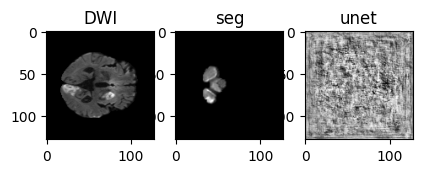

In [9]:
import matplotlib.pyplot as plt

image = folds[4]["train"][200]["image"]
expected = folds[4]["val"][200]["image"]

plt.subplot(1, 4, 1)
plt.imshow(image[0, :, :], cmap='gray')
plt.title('DWI')

plt.subplot(1, 4, 2)
plt.imshow(expected[0, :, :], cmap='gray')
plt.title('seg')


image = torch.unsqueeze(image, 0)
unet_seg = model(image)

plt.subplot(1, 4, 3)
plt.imshow(unet_seg[0, 0, :, :].detach().numpy(), cmap='gray')
plt.title('unet')

model = TransformerAttentionUNet(128, 4, 768, 3, 4)
print(model.parameters())

model.eval()
seg = model(image)
print(seg.shape)

plt.subplot(1, 4, 4)
plt.imshow(seg[0, 0, :, :].detach().numpy(), cmap='gray')
plt.title('custom')

plt.show()